In [12]:
# %cd ..
# %rm -rf phishing

/content


## Clone Git Repo

In [13]:
!git clone https://github.com/daniohren/phishing.git
%cd phishing

Cloning into 'phishing'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 114 (delta 61), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (114/114), 5.88 MiB | 5.83 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/phishing


## Import Libraries

In [0]:
# Pytorch Libraries
import torch
import torchvision
import torch.nn.functional as F

# Model Libraries
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn import ensemble

# Visualisation Libraries
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

# General
import pandas as pd
import numpy as np
import copy
import gc
import shutil
import pickle

## Load Kaggle Data

In [0]:
data_url = "phish_test_data2_features.csv"

data = pd.read_csv(data_url)

## Display sample of Data

In [15]:
data.head(10)

,IPinURL,length,shortened,at_symbol,redirect_slashes,prefsuf,subdomain,tld,https_domain,website_traffic,statistical_report,certificate,domain_age,reg_length,Result
0,1.0,-0.67,1.0,1.0,1.0,1.0,-3.0,-0.39,1.0,-1.0,1.0,1.0,0.004,0.361,-1
1,1.0,-0.98,1.0,1.0,1.0,1.0,-1.0,-0.48,1.0,-1.0,1.0,1.0,0.233,0.133,-1
2,1.0,-0.67,1.0,1.0,1.0,1.0,-3.0,-0.39,1.0,-1.0,1.0,1.0,0.004,0.361,-1
3,1.0,-0.67,1.0,1.0,1.0,1.0,-3.0,-0.39,1.0,-1.0,1.0,1.0,0.004,0.361,-1
4,1.0,-0.36,1.0,1.0,1.0,1.0,-1.0,-0.48,1.0,1.0,1.0,1.0,7.226,0.079,-1
5,1.0,-0.38,1.0,1.0,1.0,1.0,-1.0,-0.48,1.0,1.0,1.0,1.0,7.226,0.079,-1
6,1.0,-0.67,1.0,1.0,1.0,1.0,-3.0,-0.39,1.0,-1.0,1.0,-1.0,0.004,0.361,-1
7,1.0,-0.67,1.0,1.0,1.0,1.0,-3.0,-0.39,1.0,-1.0,1.0,1.0,0.004,0.361,-1
8,1.0,-0.67,1.0,1.0,1.0,1.0,-3.0,-0.39,1.0,-1.0,1.0,1.0,0.180,0.365,-1
9,1.0,-0.67,1.0,1.0,1.0,1.0,-3.0,-0.39,1.0,-1.0,1.0,1.0,0.180,0.365,-1


## Display Data Statistics

In [16]:
data.describe()

,IPinURL,length,shortened,at_symbol,redirect_slashes,prefsuf,subdomain,tld,https_domain,website_traffic,statistical_report,certificate,domain_age,reg_length,Result
count,617.000000,617.000000,617.0,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,0.974068,-1.358833,1.0,0.987034,0.993517,0.769854,-0.539708,-0.416791,0.996759,0.053485,0.983793,0.153971,2.503697,0.460621,0.115073
std,0.226439,1.720178,0.0,0.160641,0.113776,0.638738,0.673329,0.406688,0.080517,0.999379,0.179456,0.988877,2.842586,0.598266,0.994163
min,-1.000000,-24.420000,1.0,-1.000000,-1.000000,-1.000000,-4.000000,-7.700000,-1.000000,-1.000000,-1.000000,-1.000000,0.004000,0.001000,-1.000000
25%,1.000000,-1.610000,1.0,1.000000,1.000000,1.000000,-1.000000,-0.480000,1.000000,-1.000000,1.000000,-1.000000,0.180000,0.184000,-1.000000
50%,1.000000,-0.730000,1.0,1.000000,1.000000,1.000000,0.000000,-0.480000,1.000000,1.000000,1.000000,1.000000,2.008000,0.360000,1.000000
75%,1.000000,-0.470000,1.0,1.000000,1.000000,1.000000,0.000000,-0.390000,1.000000,1.000000,1.000000,1.000000,4.204000,0.365000,1.000000
max,1.000000,-0.190000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,12.475000,3.172000,1.000000


## Shuffle Dataset

In [0]:
# Shuffle dataset
data = data.sample(frac = 1).reset_index(drop = True)
data_x = data.drop(['Result'], axis = 1).to_numpy()
data_y = data['Result'].to_numpy()
class_list = sorted(list(set(data_y)))
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, stratify=data_y)

## Add new features
Engineering 2 additional columns:
1. Sum of all features.
2. Number of non-zero features.
3. Variance of all features.

In [0]:
sum_x = np.sum(train_x, axis = 1).reshape(-1, 1)
non_zeros_x = np.count_nonzero(train_x, axis = 1).reshape(-1, 1)
var_x = np.var(train_x, axis = 1).reshape(-1, 1)
new_train_x = np.hstack((train_x, sum_x, var_x, non_zeros_x))

sum_x = np.sum(test_x, axis = 1).reshape(-1, 1)
non_zeros_x = np.count_nonzero(test_x, axis = 1).reshape(-1, 1)
var_x = np.var(test_x, axis = 1).reshape(-1, 1)
new_test_x = np.hstack((test_x, sum_x, var_x, non_zeros_x))

## Plot Train Data Distribution

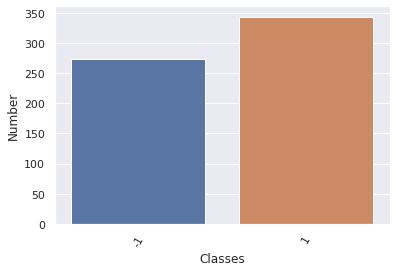

In [20]:
sns.set(style="darkgrid")
ax = sns.countplot(x = "Result", data = data, order = class_list)
ax.set_xlabel("Classes")
ax.set_ylabel("Number")
labels = ax.get_xticklabels()
for label in labels:
    label.set_rotation(60)
plt.rcParams['figure.figsize'] = (5,5)
plt.show()

## Try default parameters

In [22]:
 xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', gamma = 1,  tree_method = 'gpu_hist', nthread = -1, verbosity = 2)
 xgb_model.fit(new_train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=2)

In [23]:
xgb_model.score(new_test_x,test_y)

0.9754901960784313

## Grid Search using XGBoost Model

In [24]:
 xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', gamma = 1,  tree_method = 'gpu_hist', nthread = -1, verbosity = 2)
 params = {
     'learning_rate' : [0.05, 0.1, 0.5],
     'n_estimators' : [200, 400, 600],
     'max_depth' : [6, 9, 12],
     'subsample': [0.5, 0.8, 1],
     'colsample_bytree': [0.5, 0.8, 1],
     'colsample_bylevel': [0.5, 0.8, 1],
 }
 xgb_gsm = RandomizedSearchCV(xgb_model, params, n_iter = 10, scoring = ['neg_log_loss', 'accuracy'], n_jobs = -1 , 
                              refit = 'neg_log_loss', cv = 4, verbose = 2, random_state = 7)
 xgb_gsm.fit(new_train_x, train_y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.6min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=1,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=-1,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scal...
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.5, 0.8, 1],
                                        'c

In [25]:
xgb_gsm.best_params_

{'colsample_bylevel': 1,
 'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 12,
 'n_estimators': 200,
 'subsample': 1}

## Best Params

{'colsample_bylevel': 1,
 'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 12,
 'n_estimators': 200,
 'subsample': 1}

## Best Model
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=2)

In [0]:
xgb_model_best = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.5, gamma=1,
                learning_rate=0.1, max_delta_step=0, max_depth=12,
                min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
                nthread=-1, objective='binary:logistic', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1,tree_method='gpu_hist',verbosity=2)
xgb_model_best.fit(new_train_x,train_y)

# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(xgb_model_best, open(filename, "wb"))

## Predict on Test

In [31]:
xgb_model_best.score(new_test_x,test_y)

0.9705882352941176

## Experiments

In [0]:
## Testing
sk_folds = StratifiedKFold(n_splits = 3)

tot_loss = 0
tot_acc = 0
count = 1
for train_idx, val_idx in sk_folds.split(new_train_x, train_y):
    x_train, y_train = new_train_x[train_idx], train_y[train_idx]
    x_val, y_val = new_train_x[val_idx], train_y[val_idx]
    xgb_model_best.fit(x_train, y_train)

    # Train
    train_preds = xgb_model_best.predict_proba(x_train)
    train_loss = log_loss(y_train, train_preds)
    
    # Val
    val_preds = xgb_model_best.predict_proba(x_val)
    val_loss = log_loss(y_val, val_preds)
    val_acc = accuracy_score(y_val, xgb_model_best.predict(x_val))

    print("Split: {0}\tTraining Loss:{1:.4f}\tValidation Loss:{2:.4f}".format(count, train_loss, val_loss))

    # Total
    tot_loss += val_loss
    tot_acc += val_acc
    count+=1
print("\nAverage Loss:{}\nAverage Accuracy:{}".format(tot_loss/3, (tot_acc/3)*100))